In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import uniform, randint, loguniform
from sklearn.ensemble import VotingClassifier

In [2]:
df_train = pd.read_csv("P:/notebooks/competition KAGGLE/data/Diabetes Prediction Challenge/train.csv")
df_test = pd.read_csv("P:/notebooks/competition KAGGLE/data/Diabetes Prediction Challenge/test.csv")

In [11]:
df_train.isna().sum()

age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi_age                               0


In [4]:
target = df_train["diagnosed_diabetes"]
idk = df_test["id"]
df_train = df_train.drop(columns=["diagnosed_diabetes", "id"])
df_test = df_test.drop(columns=["id"])

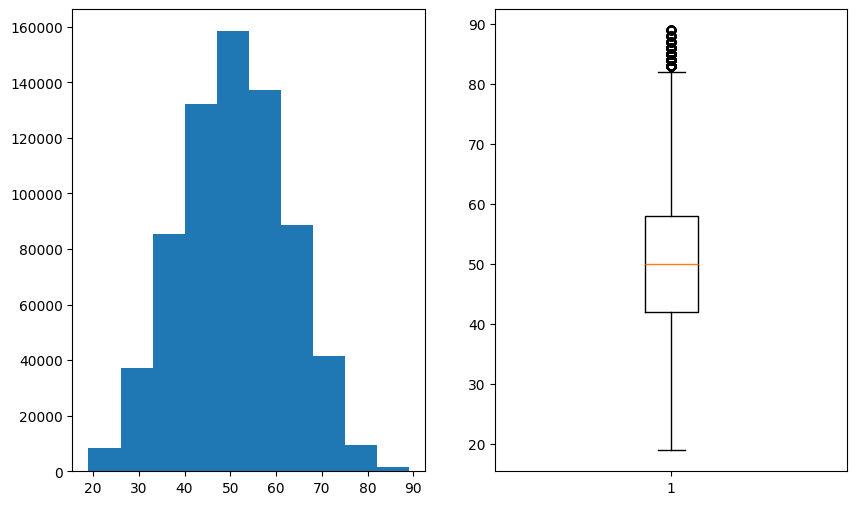

In [5]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(x=df_train["age"])
plt.subplot(1,2,2)
plt.boxplot(x=df_train["age"])
plt.show()

In [6]:
# bmi * age
df_train['bmi_age'] = df_train['bmi'] * df_train['age']
df_test['bmi_age'] = df_test['bmi'] * df_test['age']

In [7]:
# systolic_bp / diastolic_bp
df_train['sys_dia_bp'] = df_train['systolic_bp'] / df_train['diastolic_bp']
df_test['sys_dia_bp'] = df_test['systolic_bp'] / df_test['diastolic_bp']

In [8]:
# screen time hours / sleep hours
df_train['screen_time_vs_sleep'] = df_train['screen_time_hours_per_day'] / df_train['sleep_hours_per_day']
df_test['screen_time_vs_sleep'] = df_test['screen_time_hours_per_day'] / df_test['sleep_hours_per_day']

In [9]:
# Cholesterol Ratio
df_train['chol_ratio'] = df_train['ldl_cholesterol'] / (df_train['hdl_cholesterol'] + 1)
df_test['chol_ratio'] = df_test['ldl_cholesterol'] / (df_test['hdl_cholesterol'] + 1)

In [10]:
X = df_train
y = target

In [12]:
cat_cols = df_train[['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']].columns.tolist()
num_cols = [col for col in X.columns if col not in cat_cols]

In [13]:
preproccesing_tree = ColumnTransformer(transformers=[
    ('num_cols', 'passthrough', num_cols),
    ('cat_cols', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [14]:
pipe_tree = Pipeline(steps=[
    ('prep', preproccesing_tree),
    ('tree', DecisionTreeClassifier(random_state=42))
])

In [15]:
preproccesing_logreg = ColumnTransformer(transformers=[
    ('num_cols', StandardScaler(), num_cols),
    ('cat_cols', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [16]:
pipe_logreg = Pipeline(steps=[
    ('prep', preproccesing_logreg),
    ('logreg', LogisticRegression())
])

In [17]:
param_tree = {
    'tree__max_depth': randint(5,25),
    'tree__min_samples_split': randint(2,30),
    'tree__min_samples_leaf': randint(1,30),
    'tree__max_features': uniform(0.6, 0.4),
    'tree__ccp_alpha': loguniform(1e-6, 1e-3),
}

rscv_tree = RandomizedSearchCV(
    estimator=pipe_tree,
    param_distributions=param_tree,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42, 
    n_jobs=-1
)

rscv_tree.fit(X, y)

print(rscv_tree.best_score_)
print(rscv_tree.best_params_)

0.7004354081909748
{'tree__ccp_alpha': np.float64(2.2464551680532624e-05), 'tree__max_depth': 22, 'tree__max_features': np.float64(0.9795542149013333), 'tree__min_samples_leaf': 28, 'tree__min_samples_split': 15}


In [18]:
param_logreg = {
    'logreg__C': loguniform(1e-2, 10),
    'logreg__penalty': ['l2'],
    'logreg__solver': ['saga', 'sag', 'lbfgs'],
}

rscv_logreg = RandomizedSearchCV(
    estimator=pipe_logreg,
    param_distributions=param_logreg,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42, 
    n_jobs=-1
)

rscv_logreg.fit(X,y)

print(rscv_logreg.best_score_)
print(rscv_logreg.best_params_)

0.6944010010336213
{'logreg__C': np.float64(7.886714129990489), 'logreg__penalty': 'l2', 'logreg__solver': 'sag'}


c:\Users\polis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [19]:
best_tree_params = {k.replace('tree__',''): v for k,v in rscv_tree.best_params_.items()}
best_logreg_params = {k.replace('logreg__',''): v for k,v in rscv_logreg.best_params_.items()}

In [20]:
ensemble = VotingClassifier(estimators=[
    ('tree', Pipeline(steps=[
        ('prep', preproccesing_tree),
        ('best_tree', DecisionTreeClassifier(**best_tree_params))        
])),
    ('logreg', Pipeline(steps=[
        ('prep', preproccesing_logreg),
        ('best_logreg', LogisticRegression(**best_logreg_params))        
]))],
    voting='soft'
)

ensemble.fit(X,y)

c:\Users\polis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,estimators,"[('tree', ...), ('logreg', ...)]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,transformers,"[('num_cols', ...), ('cat_cols', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


In [21]:
pred = ensemble.predict_proba(df_test)[:,1]

In [22]:
submission = pd.DataFrame({
    "id": idk,
    "loan_paid_back": pred
})

In [23]:
submission.to_csv("P:/notebooks/competition KAGGLE/answer/Diabetes Prediction Challenge/submission.csv", index=False)